## Predict sonic log from other geophysical logs with scikit-learn
Matteo Niccoli, MyCarta
Calgary, Alberta, Canada

Blog: mycarta.wordpress.com

Twitter:@my_carta

### PRELIMINARIES

#### NB this notebooks runs in Python 3.6

In [1]:
# Import main libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns

### IMPORT, SUMMARIZE, FIRST LOOK AT THE DATA

First we import the logs from a csv file as a Pandas DataFrame, and check the data.

In [2]:
logs0 = pd.read_csv('qsiwell2_predict.csv')

print (logs0.columns)
print (logs0.head(5))
print(logs0.dtypes)

Index(['DEPTH', 'VP', 'VS', 'RHO_OLD', 'GR', 'NPHI', 'RHO', 'SW', 'SWX',
       'VPVS', 'IP', 'IS', 'VSH', 'RHOm', 'RHOf', 'PHI'],
      dtype='object')
     DEPTH      VP     VS  RHO_OLD     GR  NPHI   RHO   SW  SWX  VPVS  \
0  2013.25  2294.7  876.9     2.00  91.88  0.49   NaN  NaN  NaN  2.62   
1  2013.41  2296.7  943.0     2.05  86.80  0.48  2.24  1.0  1.0  2.44   
2  2013.56  2290.4  912.5     2.11  86.00  0.45  2.24  1.0  1.0  2.51   
3  2013.71  2277.5  891.6     2.20  87.36  0.41  2.24  1.0  1.0  2.55   
4  2013.86  2262.0  890.5     2.20  90.40  0.43  2.24  1.0  1.0  2.54   

        IP       IS   VSH  RHOm  RHOf   PHI  
0      NaN      NaN  0.49  2.73   NaN   NaN  
1  5144.85  2112.42  0.44  2.72  1.09  0.29  
2  5135.74  2046.09  0.43  2.72  1.09  0.29  
3  5107.98  1999.68  0.44  2.72  1.09  0.29  
4  5067.02  1994.78  0.48  2.73  1.09  0.30  
DEPTH      float64
VP         float64
VS         float64
RHO_OLD    float64
GR         float64
NPHI       float64
RHO        float64

Let's remove a few columns we will not use, and the first row, which had a few empty cells, and check the data again.

In [3]:
col_names = ['VS','RHO_OLD','SW','SWX','VPVS','IP','IS','VSH','RHOm','RHOf','PHI']
logs0.drop(col_names, axis=1, inplace=True)

logs0=logs0.iloc[1:,:] # first row had some empty cells
 
print (logs0.shape) # number of rows and columns
print (logs0.head(3)) # display first 3 rows
print(logs0.dtypes) # column data types

(4116, 5)
     DEPTH      VP     GR  NPHI   RHO
1  2013.41  2296.7  86.80  0.48  2.24
2  2013.56  2290.4  86.00  0.45  2.24
3  2013.71  2277.5  87.36  0.41  2.24
DEPTH    float64
VP       float64
GR       float64
NPHI     float64
RHO      float64
dtype: object


In [4]:
print (logs0.shape) # checking number of rows and columns

(4116, 5)


Let's look at the target VP sonic log versus depth

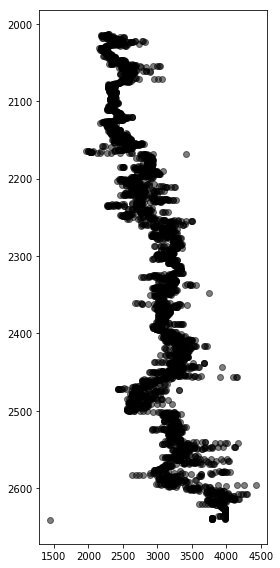

In [5]:
fig = plt.figure(figsize=(4,8))
ax1 = fig.add_subplot(111)

ax1.scatter(logs0["VP"], logs0["DEPTH"], color = 'k', alpha=0.5)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

There's one obvious bad value at max depth that we can eliminate (it's the lowest value of VP, easily highlighted).

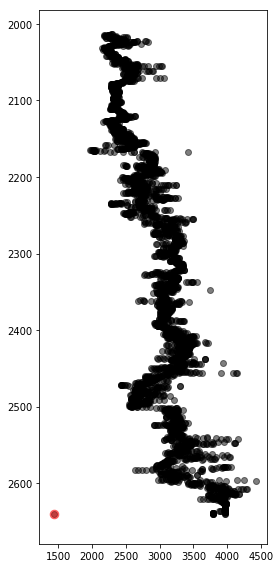

In [6]:
fig = plt.figure(figsize=(4,8))
ax1 = fig.add_subplot(111)

ax1.scatter(logs0["VP"], logs0["DEPTH"], color = 'k', alpha=0.5)
templogs = logs0[(logs0["VP"]==logs0["VP"].min())]
ax1.scatter(templogs["VP"], templogs["DEPTH"], s=75, color = 'r', alpha=0.5)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Now we can remove the data point, then plot again.

In [7]:
logs0 = logs0[~(logs0["VP"]==logs0["VP"].min())]

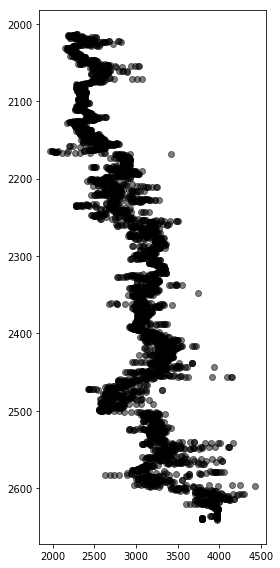

In [8]:
fig = plt.figure(figsize=(4,8))
ax1 = fig.add_subplot(111)

ax1.scatter(logs0["VP"], logs0["DEPTH"], color = 'k', alpha=0.5)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

### CLEAN-UP DATA

#### Dealing with nulls

The first task is to deal with any missing data. We can use Pandas' .isnull() method to tell us if a column had any null values and how many.

In [9]:
for x in logs0.columns:
  print (x, logs0[x].isnull().values.any())

print(logs0.isnull().sum()) # finds how many missing points there are

DEPTH False
VP False
GR False
NPHI False
RHO True
DEPTH       0
VP          0
GR          0
NPHI        0
RHO      1414
dtype: int64


By the way, I found some very good examples on the various ways to deal with missing data in Pandas dataframes in <a href="http://chrisalbon.com/python/pandas_missing_data.html"> this article. </a>


Anyway, it looks like there are several missing data points in the density log. We will replace missing density values with the mean density, then check again.

In [10]:
logs0['RHO'].fillna(logs0['RHO'].mean(),inplace=True)

for x in logs0.columns:
  print(x, logs0[x].isnull().values.any())

DEPTH False
VP False
GR False
NPHI False
RHO False


#### Despiking logs

I think despiking logs will help predictions.

In [11]:
list(logs0)

['DEPTH', 'VP', 'GR', 'NPHI', 'RHO']

In [12]:
logs = logs0.copy(deep=True)
window = 17
for i in list(logs0):
    logs[i] = pd.Series(logs[i]).rolling(window=window, min_periods=1).mean()

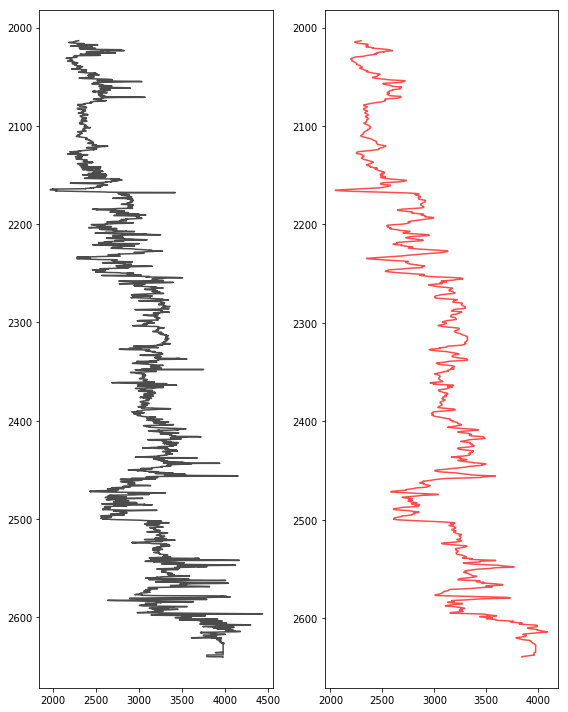

In [13]:
fig = plt.figure(figsize=(8,10))
ax1 = fig.add_subplot(121)
ax1.plot( logs0["VP"], logs0["DEPTH"],'k', alpha=0.7)
plt.gca().invert_yaxis()
ax2 = fig.add_subplot(122)
ax2.plot( logs["VP"], logs["DEPTH"],'r', alpha=0.7)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

### CHECK SCATTER MATRIX AND CORRELATION COEFFICIENTS

Let's create a scatter matrix with the pairwise scatter plots and hystogram distribution in the main diagonal.

This can help learn the data, and answer several questions, among which:
- are there obvious distributions (normal, exponential, etc.)?
- are there any obvious linear relationships between the target log and any of the independent logs?

For more on these topics, please see: <a href="http://greenteapress.com/thinkstats/html/index.html"> Think Stats, by Allen B. Downey</a>.

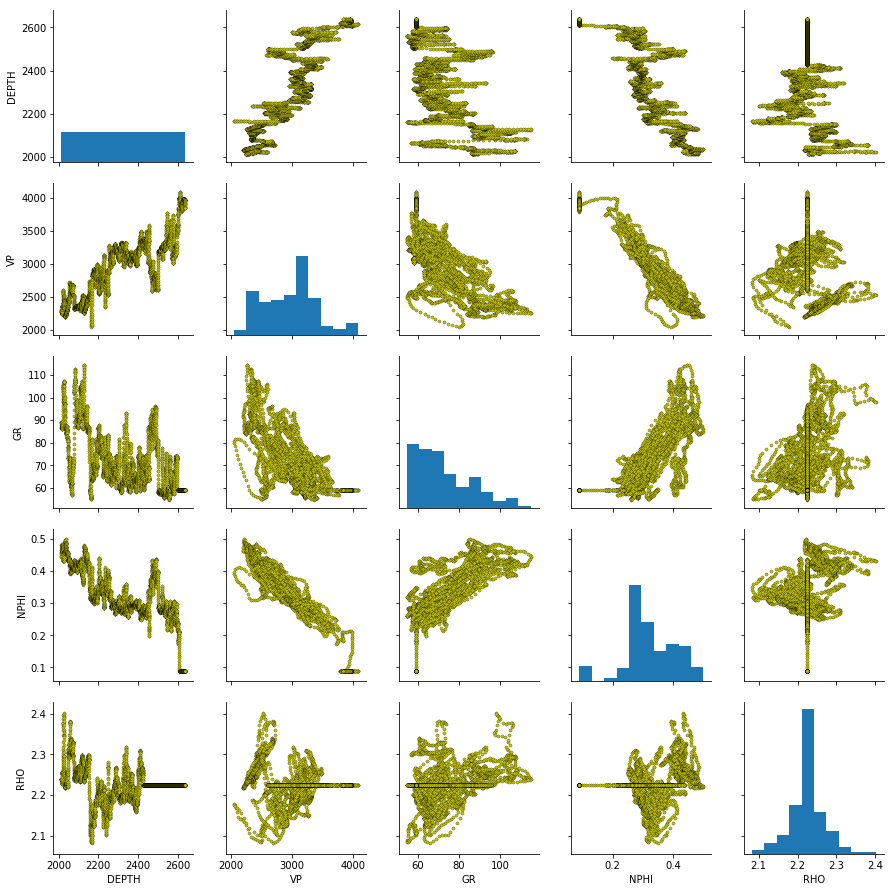

In [14]:
g = sns.PairGrid(logs)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter, s=10, color = "y", edgecolor="k", linewidth= 0.2);

By just looking at the scatterplots I'd say there is some hope to predict the sonic from the other logs. 

We can print the (Pearson) correlation coefficients as a matrix.

In [15]:
np.set_printoptions(precision=2)
pc= logs.corr().as_matrix()
print(pc)

[[ 1.    0.84 -0.56 -0.78 -0.18]
 [ 0.84  1.   -0.73 -0.95 -0.17]
 [-0.56 -0.73  1.    0.73  0.37]
 [-0.78 -0.95  0.73  1.    0.28]
 [-0.18 -0.17  0.37  0.28  1.  ]]


To make it prettier / more readable we add some labels to that matrix and convert it to a new DataFrame.

In [16]:
pcdf = pd.DataFrame(pc, index=list(logs.columns), 
                    columns=list(logs.columns))
pcdf

,DEPTH,VP,GR,NPHI,RHO
DEPTH,1.000000,0.836133,-0.558110,-0.778045,-0.178914
VP,0.836133,1.000000,-0.726679,-0.945061,-0.170186
GR,-0.558110,-0.726679,1.000000,0.734506,0.371267
NPHI,-0.778045,-0.945061,0.734506,1.000000,0.276921
RHO,-0.178914,-0.170186,0.371267,0.276921,1.000000


We can also get the Spearman correlation coefficients as a matrix. The Spearman cefficient is at time more suitable if the data has outliers, skewed distributions / non linear relationships. In this case (see below) the differences are minor.

In [17]:
np.set_printoptions(precision=2)
pcs= logs.corr(method='spearman').as_matrix()
print(pcs)

[[ 1.    0.82 -0.56 -0.79 -0.2 ]
 [ 0.82  1.   -0.72 -0.95 -0.2 ]
 [-0.56 -0.72  1.    0.77  0.38]
 [-0.79 -0.95  0.77  1.    0.27]
 [-0.2  -0.2   0.38  0.27  1.  ]]


In [18]:
pcsdf = pd.DataFrame(pcs, index=list(logs.columns), 
                    columns=list(logs.columns))
pcsdf

,DEPTH,VP,GR,NPHI,RHO
DEPTH,1.000000,0.822653,-0.558189,-0.791256,-0.203462
VP,0.822653,1.000000,-0.715437,-0.947971,-0.203941
GR,-0.558189,-0.715437,1.000000,0.772775,0.382284
NPHI,-0.791256,-0.947971,0.772775,1.000000,0.271768
RHO,-0.203462,-0.203941,0.382284,0.271768,1.000000


And use the .describe() method to get some statistics that "summarize" the data.

In [19]:
logs.describe()

,DEPTH,VP,GR,NPHI,RHO
count,4115.000000,4115.000000,4115.000000,4115.000000,4115.000000
mean,2325.675321,2974.608239,72.838952,0.322028,2.225222
std,181.053328,433.228644,13.154471,0.084218,0.042850
min,2013.410000,2046.658824,54.777059,0.090000,2.082941
25%,2168.929706,2607.126471,62.222941,0.278235,2.204706
50%,2325.672941,3050.282353,69.420588,0.306471,2.225198
75%,2482.416176,3248.897059,82.055882,0.390588,2.241765
max,2639.159412,4088.758824,114.620588,0.498824,2.401765


THe correlation coefficients could also be used (but  I won't be showing it in here) for attribute culling, or pruning of either redundant attributes (highly correlated between one another), or attributes that are not significant (in an inferential sense).
For example, one could look for any two pairs of independent logs that have pairwise correlation coefficient > 0.9, and eliminate one of the two.
One could also drop any of the independent logs that had correlation coefficient with the target log 
lower than the critical r. 

### MAKING PREDICTIONS. LINEAR CORRELATION IN SCIKIT-LEARN

We can now attempt to predict VP using th other columns (yes, including depth as velocity, generally speaking, increases with depth, thanks to sediment compaction).

We want to train the linear predictor on a subset of the velicty data that is different from the one we will make predictions on, which allows us to avoid overfitting. One nice way to do that is through cross validation, a process of splitting the data into several chunks called folds. Say we split the logs in five folds of the same size. In the first iteration, we combine the first four parts, train the predictor, then make predictions on the fifth part, and measure accuracy. In the second iteration, we combine the first part with the third, fourth, and fifth, train the predictor, make predictions on the second part, measure accuracy again, and so on. In this way we make predictions for the whole dataset without calculating accuracy on the same data we train our model on.

In [20]:
# iterate over possible number of cross validation folds to check scores and decide optimal fold 
from sklearn.model_selection import cross_val_score

# Import the linear regression class
from sklearn.linear_model import LinearRegression

# The columns we'll use to predict the target
predictors = ['DEPTH', 'GR', 'NPHI', 'RHO']

# Initialize our algorithm class
alg = LinearRegression()

scores = []
for i in np.arange(2, 15, 1):
    score = cross_val_score(alg, logs[predictors], logs["VP"], cv=i)
    scores.append(np.mean(score))
    # Take the mean of the scores (because we have one for each fold)

print (scores)

[0.5431155459368847, 0.45436439444971244, 0.21080324758783983, 0.2679649725526165, 0.5888568236966034, 0.481337842892927, 0.22887387778122123, -0.041354586058600235, -0.4145233862460305, 0.20407644365118774, 0.12711110181045546, -0.0465106666720686, -0.01439745020403437]


#### The scores above are low (scores are in the range 0-1. We will address this in just a bit.

For now let's just apply the number of folds (3) we jut determined in [] to run the cross validated prediction using the optimal number of folds.

In [21]:
from sklearn.model_selection import KFold

# Generate cross validation folds. It return the row indices corresponding to train and test.
# We set random_state to ensure we get the same splits every time we run this.
kf = KFold(n_splits=6, random_state=1)

# remember that predictors = ['DEPTH', 'GR', 'NPHI', 'RHO']
predictions = []
for train, test in kf.split(logs):
    # The predictors we're using the train the algorithm. Note how we only take the rows in the train folds.
    train_predictors = (logs[predictors].iloc[train,:])
    # The target we're using to train the algorithm.
    train_target = logs["VP"].iloc[train]
    # Training the algorithm using the predictors and target.
    alg.fit(train_predictors, train_target)
    # We can now make predictions on the test fold
    test_predictions = alg.predict(logs[predictors].iloc[test,:])
    predictions.append(test_predictions)
    score = np.mean(cross_val_score(alg, logs[predictors], logs["VP"], cv=6))
print (score)

0.5888568236966034


Let's just show one of the split of velocity values in the train and test set, which will clarify the reason for the low scores.

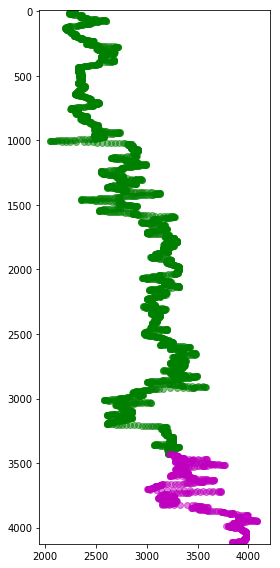

In [22]:
fig = plt.figure(figsize=(4,8))
ax1 = fig.add_subplot(111)

ax1.scatter(logs["VP"].iloc[train], np.arange(train.shape[0]), color = 'g', alpha=0.5)
ax1.scatter(logs["VP"].iloc[test], np.arange(test.min(),test.max()+1,1), color = 'm', alpha=0.5)

ax1.set_ylim([-10, logs.shape[0] + 10])
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

Because the velocity increases with depth, there is never going to be a split where the distribution of values in the train set will cover the full distribution of values in the test set. In this figure you will notice there is a lot of points with values of VP >  ~3750 m/s in the test split, but none in the train split. This is what makes the scores so poor in the output of [17]. A random shuffle prior to the prediction would take care of this problem. Prior to the shuffle we create a column with the original indices so that we can undo the shuffle if needed.

In [23]:
idx = np.array(logs.index) # get the index column in the original DataFrame
print (idx[:10])

logs["idx"] = idx # add the index and the predictions as columns to the logs DataFrame

print (list(logs)) # check new columns are in

import random # Set a random seed to make the shuffle deterministic and repeatable 
np.random.seed(1)
random.seed(1)

logs1 = logs.loc[np.random.permutation(logs.idx)] # shuffle

print (logs1.head(5)) # checking shuffle with index column

[ 1  2  3  4  5  6  7  8  9 10]
['DEPTH', 'VP', 'GR', 'NPHI', 'RHO', 'idx']
            DEPTH           VP         GR      NPHI       RHO   idx
2511  2394.710000  3005.070588  62.585294  0.291176  2.184118  2511
2750  2431.133529  3366.435294  60.471765  0.269412  2.225198  2750
3666  2570.731765  3146.070588  61.475882  0.280000  2.225198  3666
561   2097.530000  2327.564706  90.431176  0.430588  2.238235   561
2929  2458.413529  3057.070588  76.362353  0.303529  2.225198  2929


Now we chack the cross validation scores again. I expect they will be higher.

In [24]:
# Generate cross validation folds. It return the row indices corresponding to train and test.
# We set random_state to ensure we get the same splits every time we run this.
kf = KFold(n_splits=6, random_state=1)

# remember that predictors = ['DEPTH', 'GR', 'NPHI', 'RHO']
predictions = []
for train, test in kf.split(logs):
    # The predictors we're using the train the algorithm. Note how we only take the rows in the train folds.
    train_predictors = (logs1[predictors].iloc[train,:])
    # The target we're using to train the algorithm.
    train_target = logs1["VP"].iloc[train]
    # Training the algorithm using the predictors and target.
    alg.fit(train_predictors, train_target)
    # We can now make predictions on the test fold
    test_predictions = alg.predict(logs1[predictors].iloc[test,:])
    predictions.append(test_predictions)
    score = np.mean(cross_val_score(alg, logs1[predictors], logs1["VP"], cv=6))
print (score)

0.9319274162899559


And out of curiosity we can look again at the split of velocity values in the train and test set.

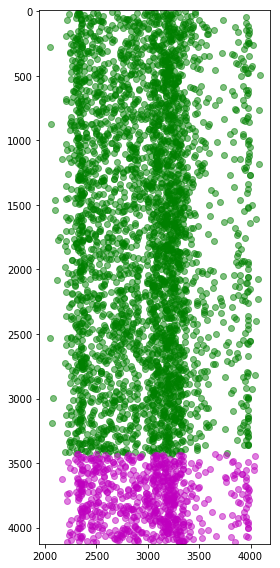

In [25]:
fig = plt.figure(figsize=(4,8))
ax1 = fig.add_subplot(111)

ax1.scatter(logs1["VP"].iloc[train], np.arange(train.shape[0]), color = 'g', alpha=0.5)
ax1.scatter(logs1["VP"].iloc[test], np.arange(test.min(),test.max()+1,1), color = 'm', alpha=0.5)

ax1.set_ylim([-10, logs1.shape[0] + 10])
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

### EVALUATING PREDICTION PERFORMANCE

One way to evaluate the prediction performance is to create a baseline model against which every predicted model will have to be compared. In the absence of any predictor, if all we could use is the dependent, target log variable, the best we could do with predicting a new, unmeasured sonic value, would be to use the sonic mean. (That is not entirely correct. I think it would be correct if the values of sonic from sample to sample were completely independent, but even without the depth log, we do know that the sonic, on average, increases with sample number, at least in this geological province; so a very long running average might be a better baseline model; I will get back to this, so for now forgive the oversimplification).

In [26]:
baseline = np.full(logs1["VP"].shape, logs1["VP"].mean()) # create baseline model.
print (baseline.shape)
print (baseline [:5])

(4115,)
[2974.61 2974.61 2974.61 2974.61 2974.61]


Now we plot the baseline model consisting of cvalues equal to the mean at each sample. The diagonal line represent perfect prediction.

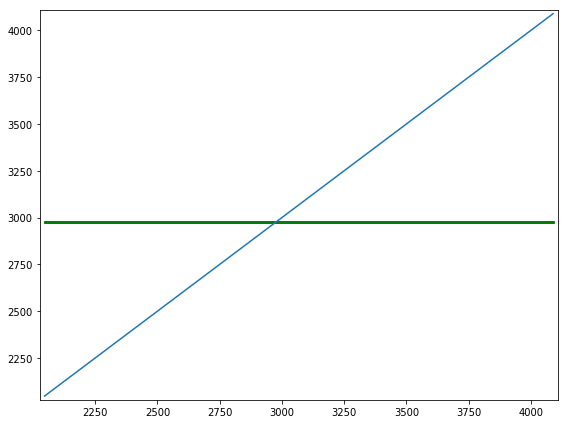

In [27]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)

ax1.scatter(np.linspace(logs1["VP"].min(), logs1["VP"].max(), logs1["VP"].shape[0]), 
            baseline, s=3, color = 'g', alpha=0.5)

ax1.plot(np.linspace(logs1["VP"].min(), logs1["VP"].max(), logs1["VP"].shape[0]), 
         np.linspace(logs1["VP"].min(), logs1["VP"].max(), logs1["VP"].shape[0]))

ax1.set_xlim([logs1["VP"].min()- 20, logs1["VP"].max() + 20])
ax1.set_ylim([logs1["VP"].min()- 20, logs1["VP"].max() + 20])

plt.tight_layout()
plt.show()

Now we can compare the result of the linear prediction agains the perfect prediction in the diagonal line.

In [28]:
prediction = np.concatenate(predictions, axis=0)
# The predictions are in three separate numpy arrays, so we need to concatenate them into one.  

In [29]:
print(prediction.shape)
print(logs1["VP"].shape)

(4115,)
(4115,)


And here's the plot of predicted versus actual, linear model. Diagonal line is perfect prediction.

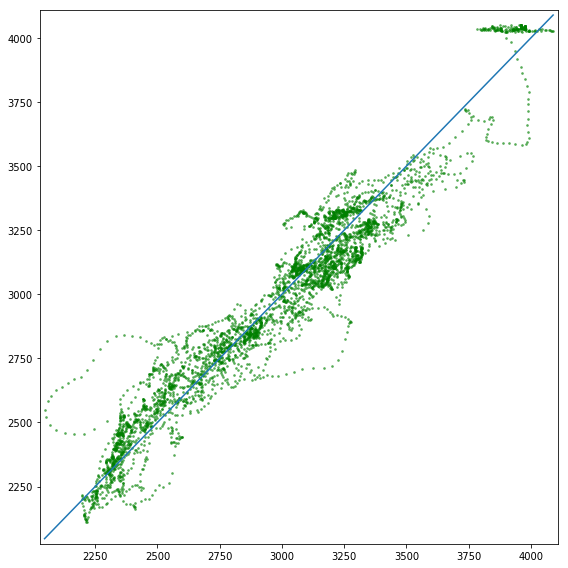

In [30]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(111)

ax1.scatter(logs1["VP"], prediction, s=3, color = 'g', alpha=0.5)

ax1.plot(np.linspace(logs1["VP"].min(), logs1["VP"].max(), logs1["VP"].shape[0]), 
         np.linspace(logs1["VP"].min(), logs1["VP"].max(), logs1["VP"].shape[0]))

ax1.set_xlim([logs1["VP"].min()- 20, logs1["VP"].max() + 20])
ax1.set_ylim([logs1["VP"].min()- 20, logs1["VP"].max() + 20])

plt.tight_layout()
plt.show()

We have definitely made an improvement in our prediction compared to the baseline model.

:-)

To conclude this part, I want to compare the predicted sonic to the actual sonic. To do that we need to undo the random shuffle in the predicted values with the indeces created earlier.

Although we can now just use srt_values on the DEPTH column (https://stackoverflow.com/a/44123892/1034648)

In [31]:
logs1["predictedVP"] = prediction # adding the prediction so it is in the final DataFrame
logs2 = logs1.sort_values(by ='DEPTH', ascending=[True])

Original versus predicted sonic, as scatter plots.

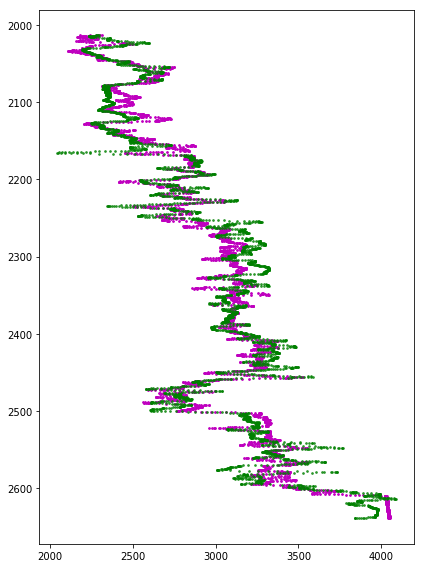

In [32]:
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(111)

ax1.scatter(logs2["predictedVP"], logs2["DEPTH"], s = 3, color = 'm')
ax1.scatter(logs2["VP"], logs2["DEPTH"], s = 3, color = 'g', alpha = 0.7)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

Original versus predicted sonic, as scatter plot mimicking lines.

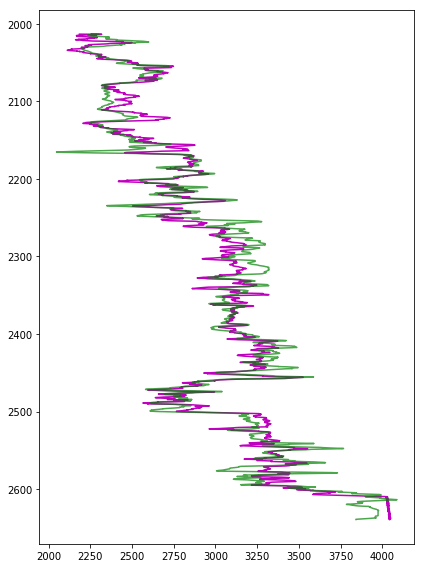

In [33]:
fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(111)
ax1.plot( logs2["predictedVP"], logs2["DEPTH"],'m')
ax1.plot( logs2["VP"], logs2["DEPTH"],'g', alpha=0.7)
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

### FUTURE WORK FOR MACHINE LEARNING

- try a different baseline model. Look at time series analysis, stock price prediction examples
- prediction using scikit-learn Random Forest
- (perhaps) prediction using scikit-learn Sup[port Vector Regression with nonlinear kernel
- adding numerical metrix to compare models to baseling and to one another (RMSE, MAE)

### MAKE ERROR FLAGS

#### Calculate error, error mean, standard deviation of error

In [34]:
err = np.abs(logs2["predictedVP"]-logs2["VP"])
err_mean = np.mean(err)
err_std = np.std(err)

print(err_mean, err_std)

87.50067790734857 71.32812564604957


#### Calculate sign of slopes

In [35]:
pred_s = np.sign(logs2["predictedVP"].diff().fillna(logs2["predictedVP"]))
actual_s = np.sign(logs2["VP"].diff().fillna(logs2["VP"]))

#### Make flags

Method 1: difference between curves larger than mean difference plus 1 std

Method 2: curve slopes have opposite sign

Method 3: opposite sign OR difference larger than mean plus 1 std

In [36]:
def err_flag(pred, actual, method, dev = 1):
    """Make error flag using three methods"""
    
    ###### input ######
    
    # predicted = predicted log
    
    # actual =  original log
    
    # method 1: difference between logs larger than mean difference plus 1 std
    # method 2: slopes have opposite sign. Requires depth log for derivative to use differ function
    # method 3: opposite sign OR difference larger than mean plus 1 std
    

    ###### output ######
    
    # flag =  error flag
    
    flag = np.zeros(len(pred))
    err = np.abs(pred-actual)
    err_mean = np.mean(err)
    err_std = np.std(err)
    ss = np.sign(pred.diff().fillna(pred))
    ls = np.sign(actual.diff().fillna(actual))

    if method == 1:
        flag[np.where(err>(err_mean + (dev*err_std)))] = 1
     
    elif method == 2:      
        flag[np.where((ss + ls)==0 )]= 1
    elif method == 3:
        flag[np.where(np.logical_or(err>(err_mean + (dev*err_std)), (ss+ls)==0 ))]= 1
    return flag

In [37]:
flag = err_flag(logs2["predictedVP"], logs2["VP"], 1,  1)

In [38]:
from matplotlib  import gridspec

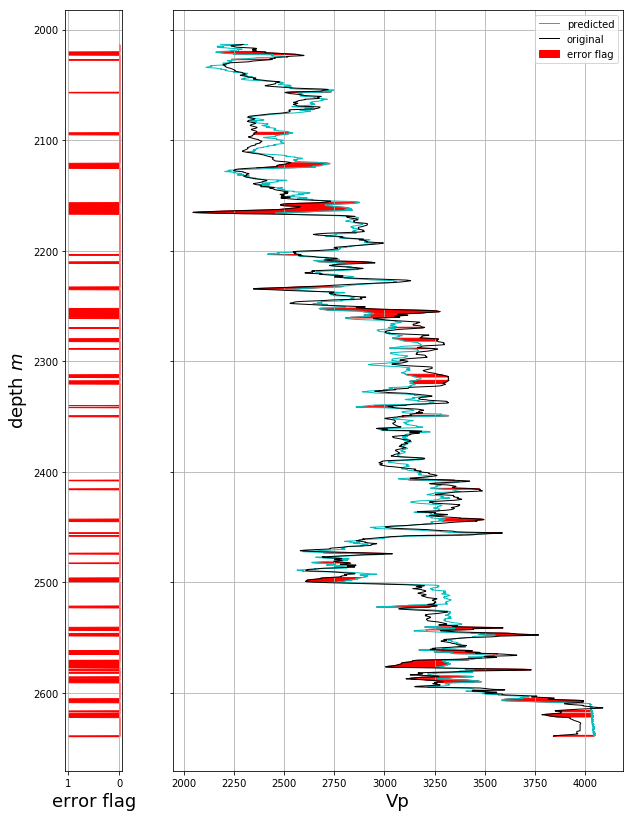

In [39]:
fig = plt.figure(figsize=(10,14))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.5, 4]) 
# https://stackoverflow.com/a/10411424

ax = plt.subplot(gs[0])
ax.set_ylabel(r'depth $m$', size=18)
ax.fill_betweenx(logs2['DEPTH'], flag, 0, color = 'r')
ax.invert_yaxis()
ax.invert_xaxis()
ax.set_xlabel('error flag', size=18)

ax.grid()

ax1 = plt.subplot(gs[1])
ax1.plot(logs2["predictedVP"], logs2["DEPTH"], 'c', label='predicted', linewidth = 1)
ax1.plot(logs2["VP"], logs2["DEPTH"], 'k', label='original', linewidth = 1)


ax1.fill_betweenx(logs2['DEPTH'], logs2["predictedVP"], logs2["VP"], where=flag==1, color = 'r', label='error flag')

# Do some plot annotations
#ax1.set_title('title here')
ax1.invert_yaxis()
ax1.set_yticklabels([])
ax1.set_xlabel('Vp', size=18)

ax1.legend()
    
ax1.grid()
#fig.savefig('file.png', dpi=250, bbox_inches='tight', pad_inches=0.2)
plt.show()


### FUTURE WORK FOR ERROR FLAGS

#### Calculating error statistics by zone if tops are provided and save as summary in a Pandas dataframe